<a href="https://colab.research.google.com/github/Jayku88/DeepLearningWorkshop_MGUniversity/blob/main/TransformerInference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#🔍 SegFormer Inference and Visualization on ADE20K Dataset Using a Local Image

https://github.com/Jayku88/DeepLearningWorkshop_MGUniversity/tree/main

**Download images from above link and upload to Files section (Left pane) in Google Colab**

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


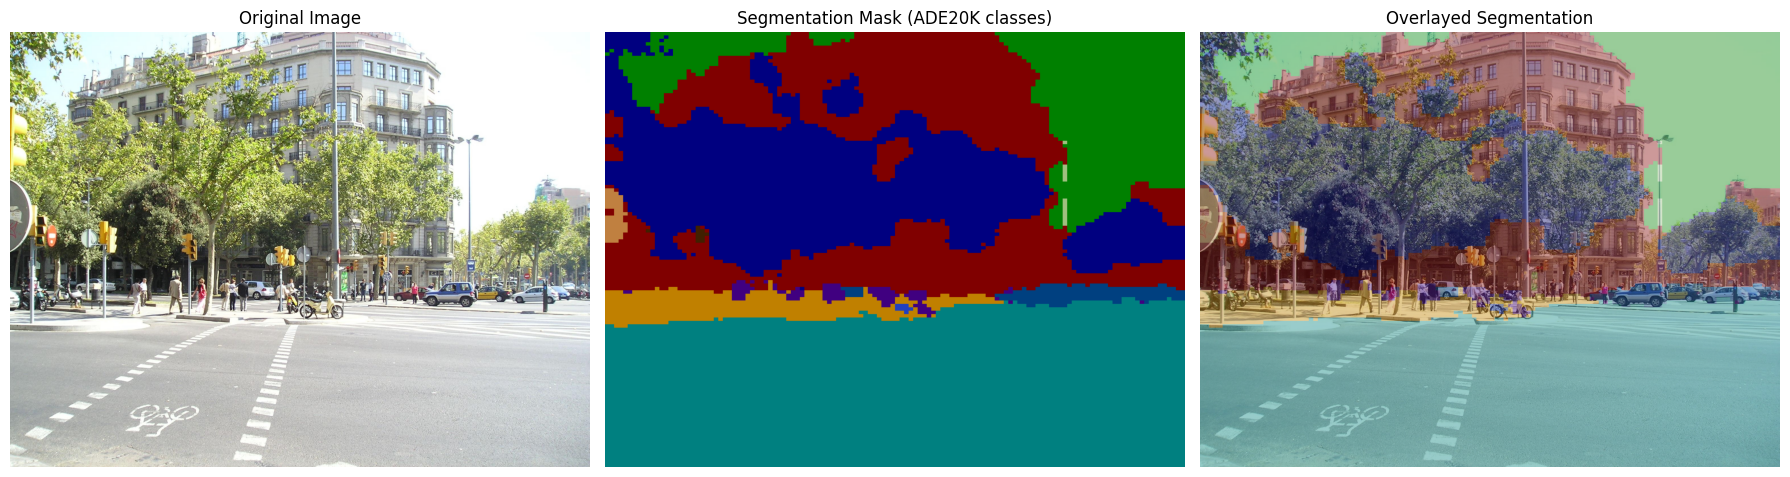

In [1]:
from transformers import AutoImageProcessor, SegformerForSemanticSegmentation
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt
import requests
import os

# 1. Upload a test image from ADE20K validation set
#image_path = "ADE_train_00016900.jpg"
image_path = "ADE_train_00016869.jpg"

# 2. Load and preprocess the image
image = Image.open(image_path).convert("RGB")
processor = AutoImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

inputs = processor(images=image, return_tensors="pt")

# 3. Inference
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits  # shape: [1, 150, H, W]

# 4. Convert logits to segmentation map
pred_classes = logits.argmax(dim=1)[0].cpu().numpy()
segmentation_mask = Image.fromarray(pred_classes.astype(np.uint8)).resize(image.size, resample=Image.NEAREST)

# 5. Generate a color palette for ADE20K (150 classes)
def ade_palette():
    palette = np.zeros((150, 3), dtype=np.uint8)
    for i in range(150):
        label = i
        r, g, b = 0, 0, 0
        for j in range(8):
            r |= (((label >> 0) & 1) << (7 - j))
            g |= (((label >> 1) & 1) << (7 - j))
            b |= (((label >> 2) & 1) << (7 - j))
            label >>= 3
        palette[i] = [r, g, b]
    return palette

palette = ade_palette()
seg_color = np.array(segmentation_mask)
colored_mask = palette[seg_color]

# 6. Overlay segmentation on original image
alpha = 0.6
overlay = (alpha * np.array(image) + (1 - alpha) * colored_mask).astype(np.uint8)

# 7. Visualization
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(colored_mask)
plt.title("Segmentation Mask (ADE20K classes)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title("Overlayed Segmentation")
plt.axis("off")

plt.tight_layout()
plt.show()


#🚧 Binary Road Segmentation Inference Using SegFormer (Custom ADE-Trained Weights)

https://github.com/Jayku88/DeepLearningWorkshop_MGUniversity/tree/main

**Download images from above link and upload to Files section (Left pane) in Google Colab**

/usr/local/lib/python3.11/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `SegformerFeatureExtractor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


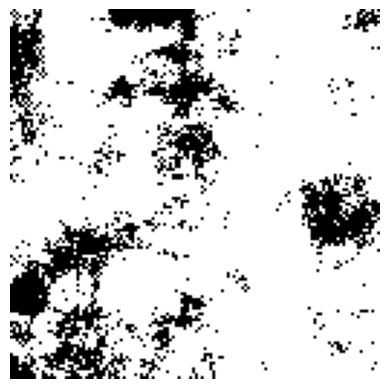

In [2]:
from transformers import SegformerConfig, SegformerFeatureExtractor, SegformerForSemanticSegmentation
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt

# 1. Feature Extractor
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

# 2. Load new config
config = SegformerConfig.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
config.num_labels = 2

# 3. Initialize new model
model = SegformerForSemanticSegmentation(config)

# (Optional) Load encoder weights
pretrained_model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model.segformer.load_state_dict(pretrained_model.segformer.state_dict())

# 4. Load and preprocess image
#image = Image.open('10378780_15_0_0.tiff').convert('RGB')
#image = Image.open('16078870_15_1_4.tiff').convert('RGB')
image = Image.open('876466_sat_0_0.jpg').convert('RGB')

inputs = feature_extractor(images=image, return_tensors="pt")

# 5. Inference
outputs = model(**inputs)
logits = outputs.logits  # shape (batch_size, 2, height, width)
segmentation = logits.argmax(dim=1)[0].cpu().numpy()

# 6. Visualization
plt.imshow(segmentation, cmap='gray')  # Use gray for binary
plt.axis('off')
plt.show()


# 🛣️ Binary Segmentation Inference with UPerNet-Swin Transformer on 512×512 Satellite Image

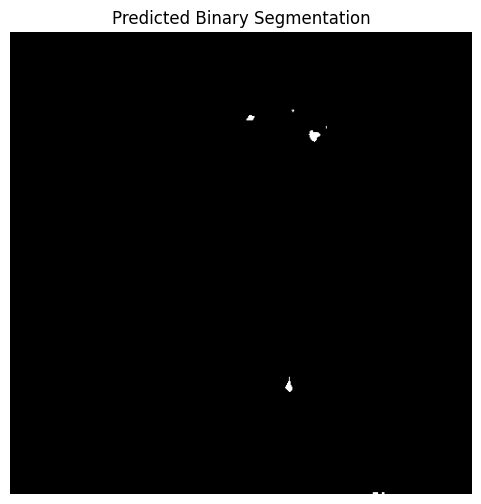

In [4]:
# Install if needed
# !pip install transformers

from transformers import UperNetForSemanticSegmentation, AutoImageProcessor
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# 1. Load pre-trained UPerNet-Swin model
model = UperNetForSemanticSegmentation.from_pretrained("openmmlab/upernet-swin-base")

# 2. Modify for binary segmentation
model.config.num_labels = 2  # Only 2 classes


model.decode_head.classifier = nn.Conv2d(
    model.decode_head.classifier.in_channels,
    2,
    kernel_size=1
)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 3. Load feature extractor
processor = AutoImageProcessor.from_pretrained("openmmlab/upernet-swin-base")
processor.do_resize = False  # Already 512x512

# 4. Load and preprocess your 512x512 image
#image_path = '10378780_15_0_0.tiff'  # Update this path
#image_path = '16078870_15_1_4.tiff'
image_path = '876466_sat_0_0.jpg'
image = Image.open(image_path).convert('RGB')

inputs = processor(images=image, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

# 5. Inference
model.eval()
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits  # (batch_size, 2, h', w')

# 6. Upsample logits back to 512x512
upsampled_logits = F.interpolate(
    logits, size=(512, 512), mode='bilinear', align_corners=False
)

# 7. Get segmentation map (0 = background, 1 = road)
segmentation = upsampled_logits.argmax(dim=1)[0].cpu().numpy()

# 8. Visualize result
plt.figure(figsize=(6,6))
plt.imshow(segmentation, cmap='gray')
plt.axis('off')
plt.title('Predicted Binary Segmentation')
plt.show()
